In [464]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt


In [465]:
np.random.seed(42)
alpha0 = np.random.uniform(0.2, 0.8)
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)
    eqn_2 = (C**2)/2 * (x - alpha0 * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]


result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0]
init_p = result[1]
interval = [np.linspace(i * 500, (i + 1) * 500, 500) for i in range(10)]
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)
massFlowrate = []
PlenumPressure = []
alpha_values = [np.full(500, alpha0)]
RNN_train = []
RNN_test = []

for i in range(0,10):  
    if i ==0:
        alpha1 = alpha0
    else:
        alpha1 = np.random.uniform(0.2, 0.8)
        alpha_values.append(np.full(500, alpha1))
    
    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alpha1)

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < 5:
        RNN_train.append([aux1, aux2, np.full(500,alpha1)])
    else:
        RNN_test.append([aux1, aux2, np.full(500,alpha1)])


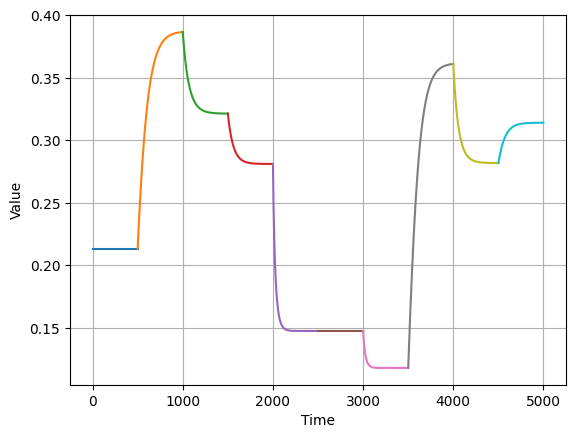

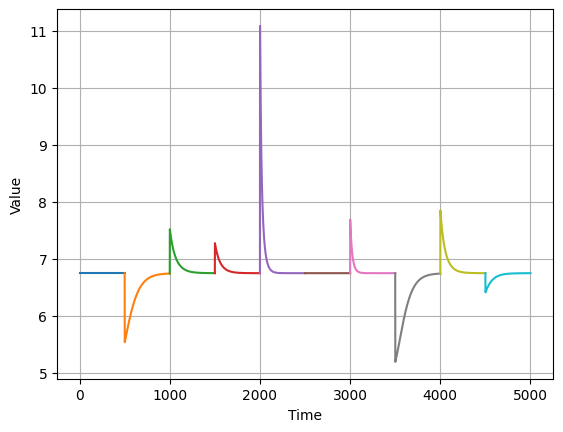

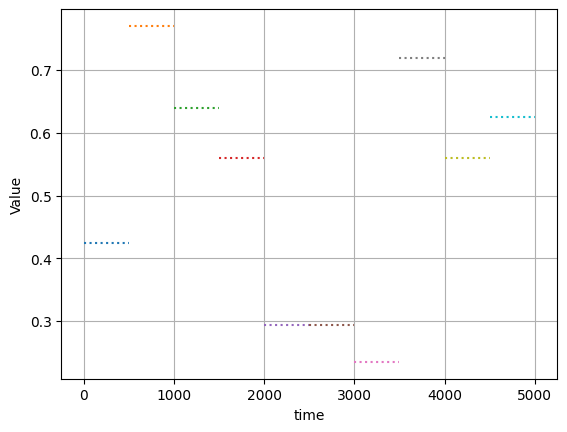

In [466]:
plt.figure("mass flow rate x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()


In [467]:
RNN_train = np.array(RNN_train)
RNN_test = np.array(RNN_test)
print(RNN_train.shape)
print(RNN_test.shape)

timestep = 4

X = []
y = []

x_test = []

for i in range(len(RNN_train[0][0])):
    X.append(RNN_train[:,:,i])
    if i == (len(RNN_train[0][0]) - 1):
        y.append(RNN_test[:, :2, 0])
    else:
        y.append(RNN_train[:,:2,i+1])
    x_test.append(RNN_test[:,:,i])


X = np.array(X)
X = X/np.max(X)
print(X.shape)
y = np.array(y)
y = y/np.max(y)

print(y.shape)

x_test = np.array(x_test)
x_testN = x_test/np.max(x_test)


(5, 3, 500)
(5, 3, 500)
(500, 5, 3)
(500, 5, 2)


In [468]:

model = keras.Sequential()
model.add(layers.Bidirectional(layers.SimpleRNN(50, input_shape=(timestep,3), return_sequences= True, activation='relu')))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2))

def lossCustom(y_true, y_pred):
    print(y_true.shape, y_pred)
    
    y_pred_flat = tf.reshape(y_pred, [-1])
    y_true_flat = tf.reshape(y_true, [-1])
    data_loss = tf.reduce_mean(tf.square(y_true_flat - y_pred_flat))
    return data_loss

model.compile(optimizer = 'adam', loss = lossCustom)


history = model.fit(X,y,epochs = 10000, verbose = 1)

Epoch 1/10000
(None, 5, 2) Tensor("sequential_82_1/dense_80_1/Add:0", shape=(None, 5, 2), dtype=float32)
(None, 5, 2) Tensor("sequential_82_1/dense_80_1/Add:0", shape=(None, 5, 2), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1060   
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0405 
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0245 
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 
Epoch 9/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 
Epoch 10/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 
Epoch 11/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 
Epoch 12/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

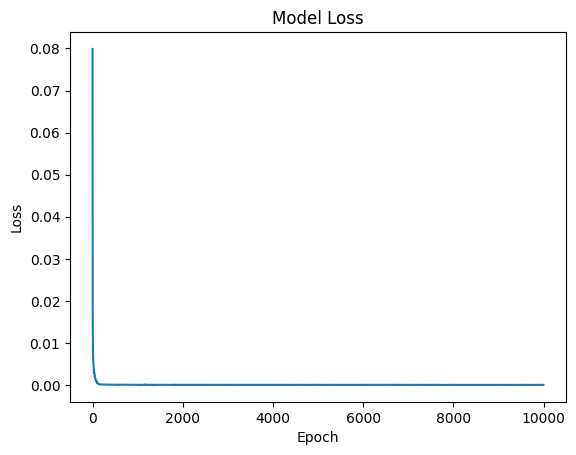

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[6.75000039 6.75000001 6.75000001 6.74340394 6.7502671 ]
 [6.7501677  7.6888162  5.19281257 7.84975814 6.41361546]
 [6.75016271 7.64510614 5.1993671  7.82733198 6.41797844]
 ...
 [6.75000001 6.75000001 6.74323532 6.75027588 6.74972054]
 [6.75000001 6.75000001 6.74332013 6.75027145 6.74972459]
 [6.75000001 6.75000001 6.74340394 6.7502671  6.74972859]]
(500, 5)
(500, 5)


/tmp/ipykernel_5827/3799110500.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_5827/3799110500.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


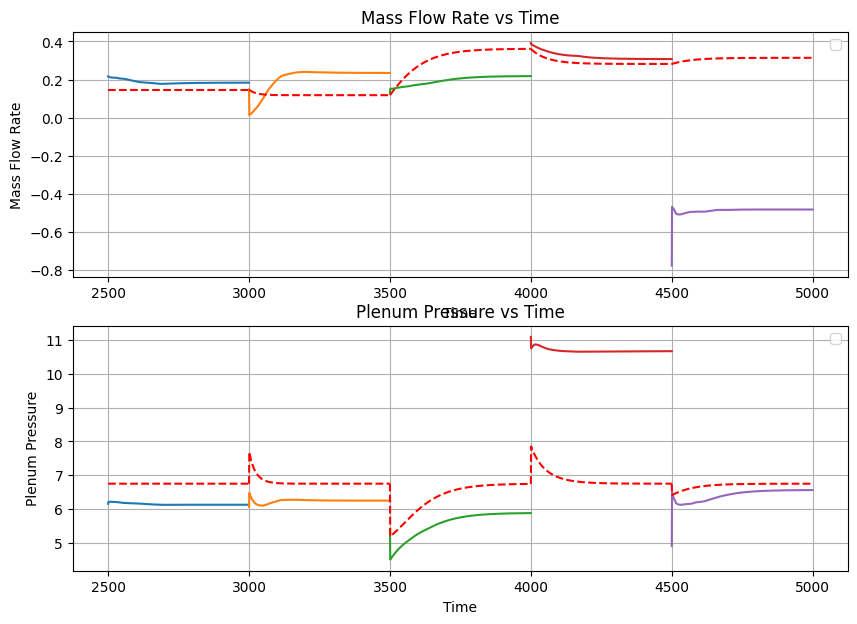

In [469]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Assuming X_new is the new data for prediction
prediction = model.predict(x_testN)
print(np.max(x_test, axis = 2))

# Extract mass and pressure from prediction
mass = prediction[:,:,0]*np.max(x_test)
print(mass.shape)
pressure = prediction[:, :,1] *np.max(x_test)
print(pressure.shape)

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7), )

# Gráfico da mass FlowRate vs. Tempo
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(mass[:,i-5]))
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do PlenumPressure vs. Tempo
for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(pressure[:,i-5]))
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

